In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from utils import train_and_validate_model, BertweetBaseMLP

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

Let's import the files developed in the preprocessing part.

# Training

In [2]:
file_path = "processed_data/aggregated_embeddings_with_labels.pkl"
merged_df = pd.read_pickle(file_path)
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

In [3]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.038894046, 0.2056955, 0.1732219, -0.0507800...",0
1,0_1,"[0.049072143, 0.20504853, 0.16913632, -0.04101...",0
2,0_10,"[-0.010199165, 0.19084008, 0.142129, -0.027013...",1
3,0_100,"[0.1076907, 0.18990463, 0.13662358, -0.0059914...",1
4,0_101,"[0.110753596, 0.21662608, 0.14855266, -0.02414...",1
...,...,...,...
2132,8_95,"[-0.12547426, 0.10333069, 0.012717849, 0.00890...",0
2133,8_96,"[-0.13536794, 0.08814793, 0.013134736, -0.0146...",1
2134,8_97,"[-0.13311367, 0.09247862, 0.016269028, 0.00072...",1
2135,8_98,"[-0.12481897, 0.07730664, 0.014376387, 0.00727...",0


In [4]:
X

array([[ 0.03889405,  0.2056955 ,  0.1732219 , ..., -0.16008152,
        -0.07019368, -0.06282356],
       [ 0.04907214,  0.20504853,  0.16913632, ..., -0.15363938,
        -0.04890908, -0.06128334],
       [-0.01019916,  0.19084008,  0.142129  , ..., -0.11866952,
        -0.05552096, -0.09124397],
       ...,
       [-0.13311367,  0.09247862,  0.01626903, ..., -0.10107715,
        -0.03391625, -0.13359854],
       [-0.12481897,  0.07730664,  0.01437639, ..., -0.10100207,
        -0.02210176, -0.1194981 ],
       [-0.13261126,  0.08881129,  0.01706956, ..., -0.11458072,
        -0.02714121, -0.13340919]], dtype=float32)

In [5]:
y

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [6]:
merged_df["EventType"].value_counts()

EventType
1    1153
0     984
Name: count, dtype: int64

The class imbalance is negligible, which is good. Given the small size of the dataset we'll do cross validation to get hopefully robust results.

In [7]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
embedding_dim = X.shape[1]
batch_size = 64

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
# setting shuffle=True ensures that the data is shuffled randomly before splitting, which helps in creating more randomized and representative folds

criterion = nn.BCEWithLogitsLoss()

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

epochs = 1000
fold_histories = []
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = BertweetBaseMLP(embedding_dim).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    
    history = train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, seed, use_tqdm=False)
    fold_histories.append(history)
    
    val_accuracy = history['val_accuracy'][-1]
    fold_accuracies.append(val_accuracy)
    
    print(f'Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}')

Fold 1/5
Epoch 1/1000
Training Loss: 0.7193, Accuracy: 0.5295
Validation Loss: 0.6919, Accuracy: 0.5444
Epoch 2/1000
Training Loss: 0.7125, Accuracy: 0.5541
Validation Loss: 0.6890, Accuracy: 0.5491
Epoch 3/1000
Training Loss: 0.6861, Accuracy: 0.5506
Validation Loss: 0.6743, Accuracy: 0.5701
Epoch 4/1000
Training Loss: 0.6899, Accuracy: 0.5670
Validation Loss: 0.6594, Accuracy: 0.6075
Epoch 5/1000
Training Loss: 0.6876, Accuracy: 0.5676
Validation Loss: 0.6530, Accuracy: 0.6192
Epoch 6/1000
Training Loss: 0.6699, Accuracy: 0.5851
Validation Loss: 0.6466, Accuracy: 0.6332
Epoch 7/1000
Training Loss: 0.6653, Accuracy: 0.5898
Validation Loss: 0.6431, Accuracy: 0.6495
Epoch 8/1000
Training Loss: 0.6521, Accuracy: 0.6080
Validation Loss: 0.6386, Accuracy: 0.6379
Epoch 9/1000
Training Loss: 0.6496, Accuracy: 0.6126
Validation Loss: 0.6350, Accuracy: 0.6425
Epoch 10/1000
Training Loss: 0.6381, Accuracy: 0.6261
Validation Loss: 0.6312, Accuracy: 0.6308
Epoch 11/1000
Training Loss: 0.6331, Acc

In [9]:
average_accuracy = sum(fold_accuracies) / k_folds
print(f'Average Validation Accuracy: {average_accuracy:.4f}')

Average Validation Accuracy: 0.7632


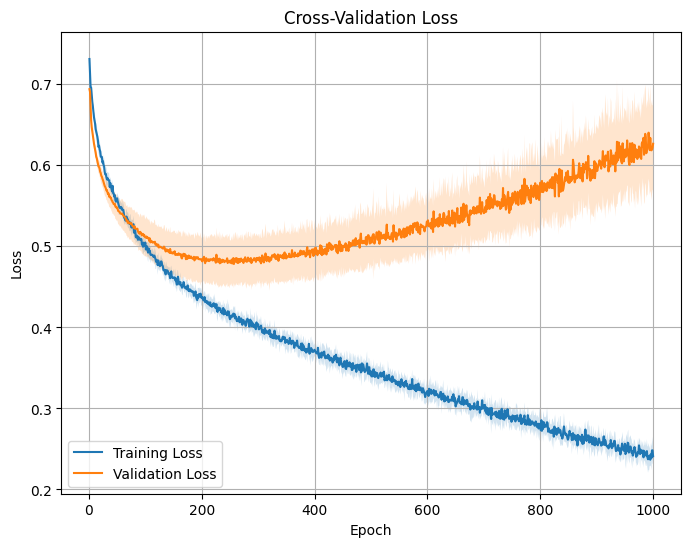

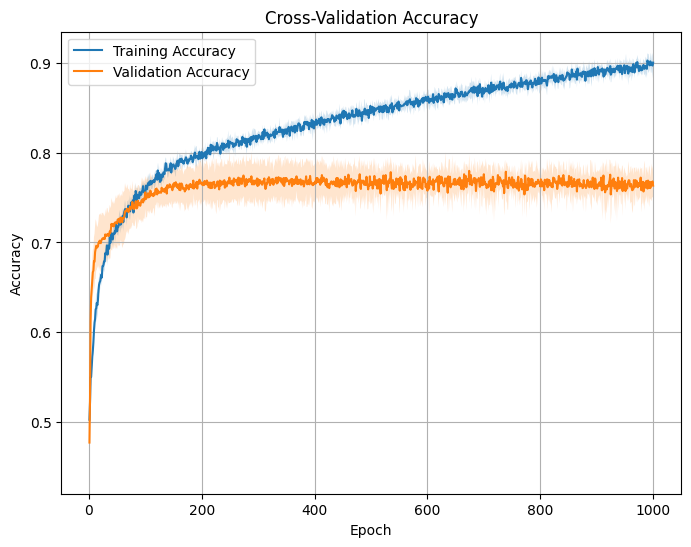

In [10]:
num_epochs = epochs
num_folds = k_folds

# Initialize arrays to store metrics
train_loss_all = np.zeros((num_folds, num_epochs))
val_loss_all = np.zeros((num_folds, num_epochs))
train_acc_all = np.zeros((num_folds, num_epochs))
val_acc_all = np.zeros((num_folds, num_epochs))

# Populate arrays with data from each fold
for i, history in enumerate(fold_histories):
    train_loss_all[i] = history['train_loss']
    val_loss_all[i] = history['val_loss']
    train_acc_all[i] = history['train_accuracy']
    val_acc_all[i] = history['val_accuracy']

# Compute mean and standard deviation
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

epochs_range = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss_mean, label='Training Loss')
plt.fill_between(epochs_range, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.2)
plt.plot(epochs_range, val_loss_mean, label='Validation Loss')
plt.fill_between(epochs_range, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross-Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_mean, label='Training Accuracy')
plt.fill_between(epochs_range, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha=0.2)
plt.plot(epochs_range, val_acc_mean, label='Validation Accuracy')
plt.fill_between(epochs_range, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

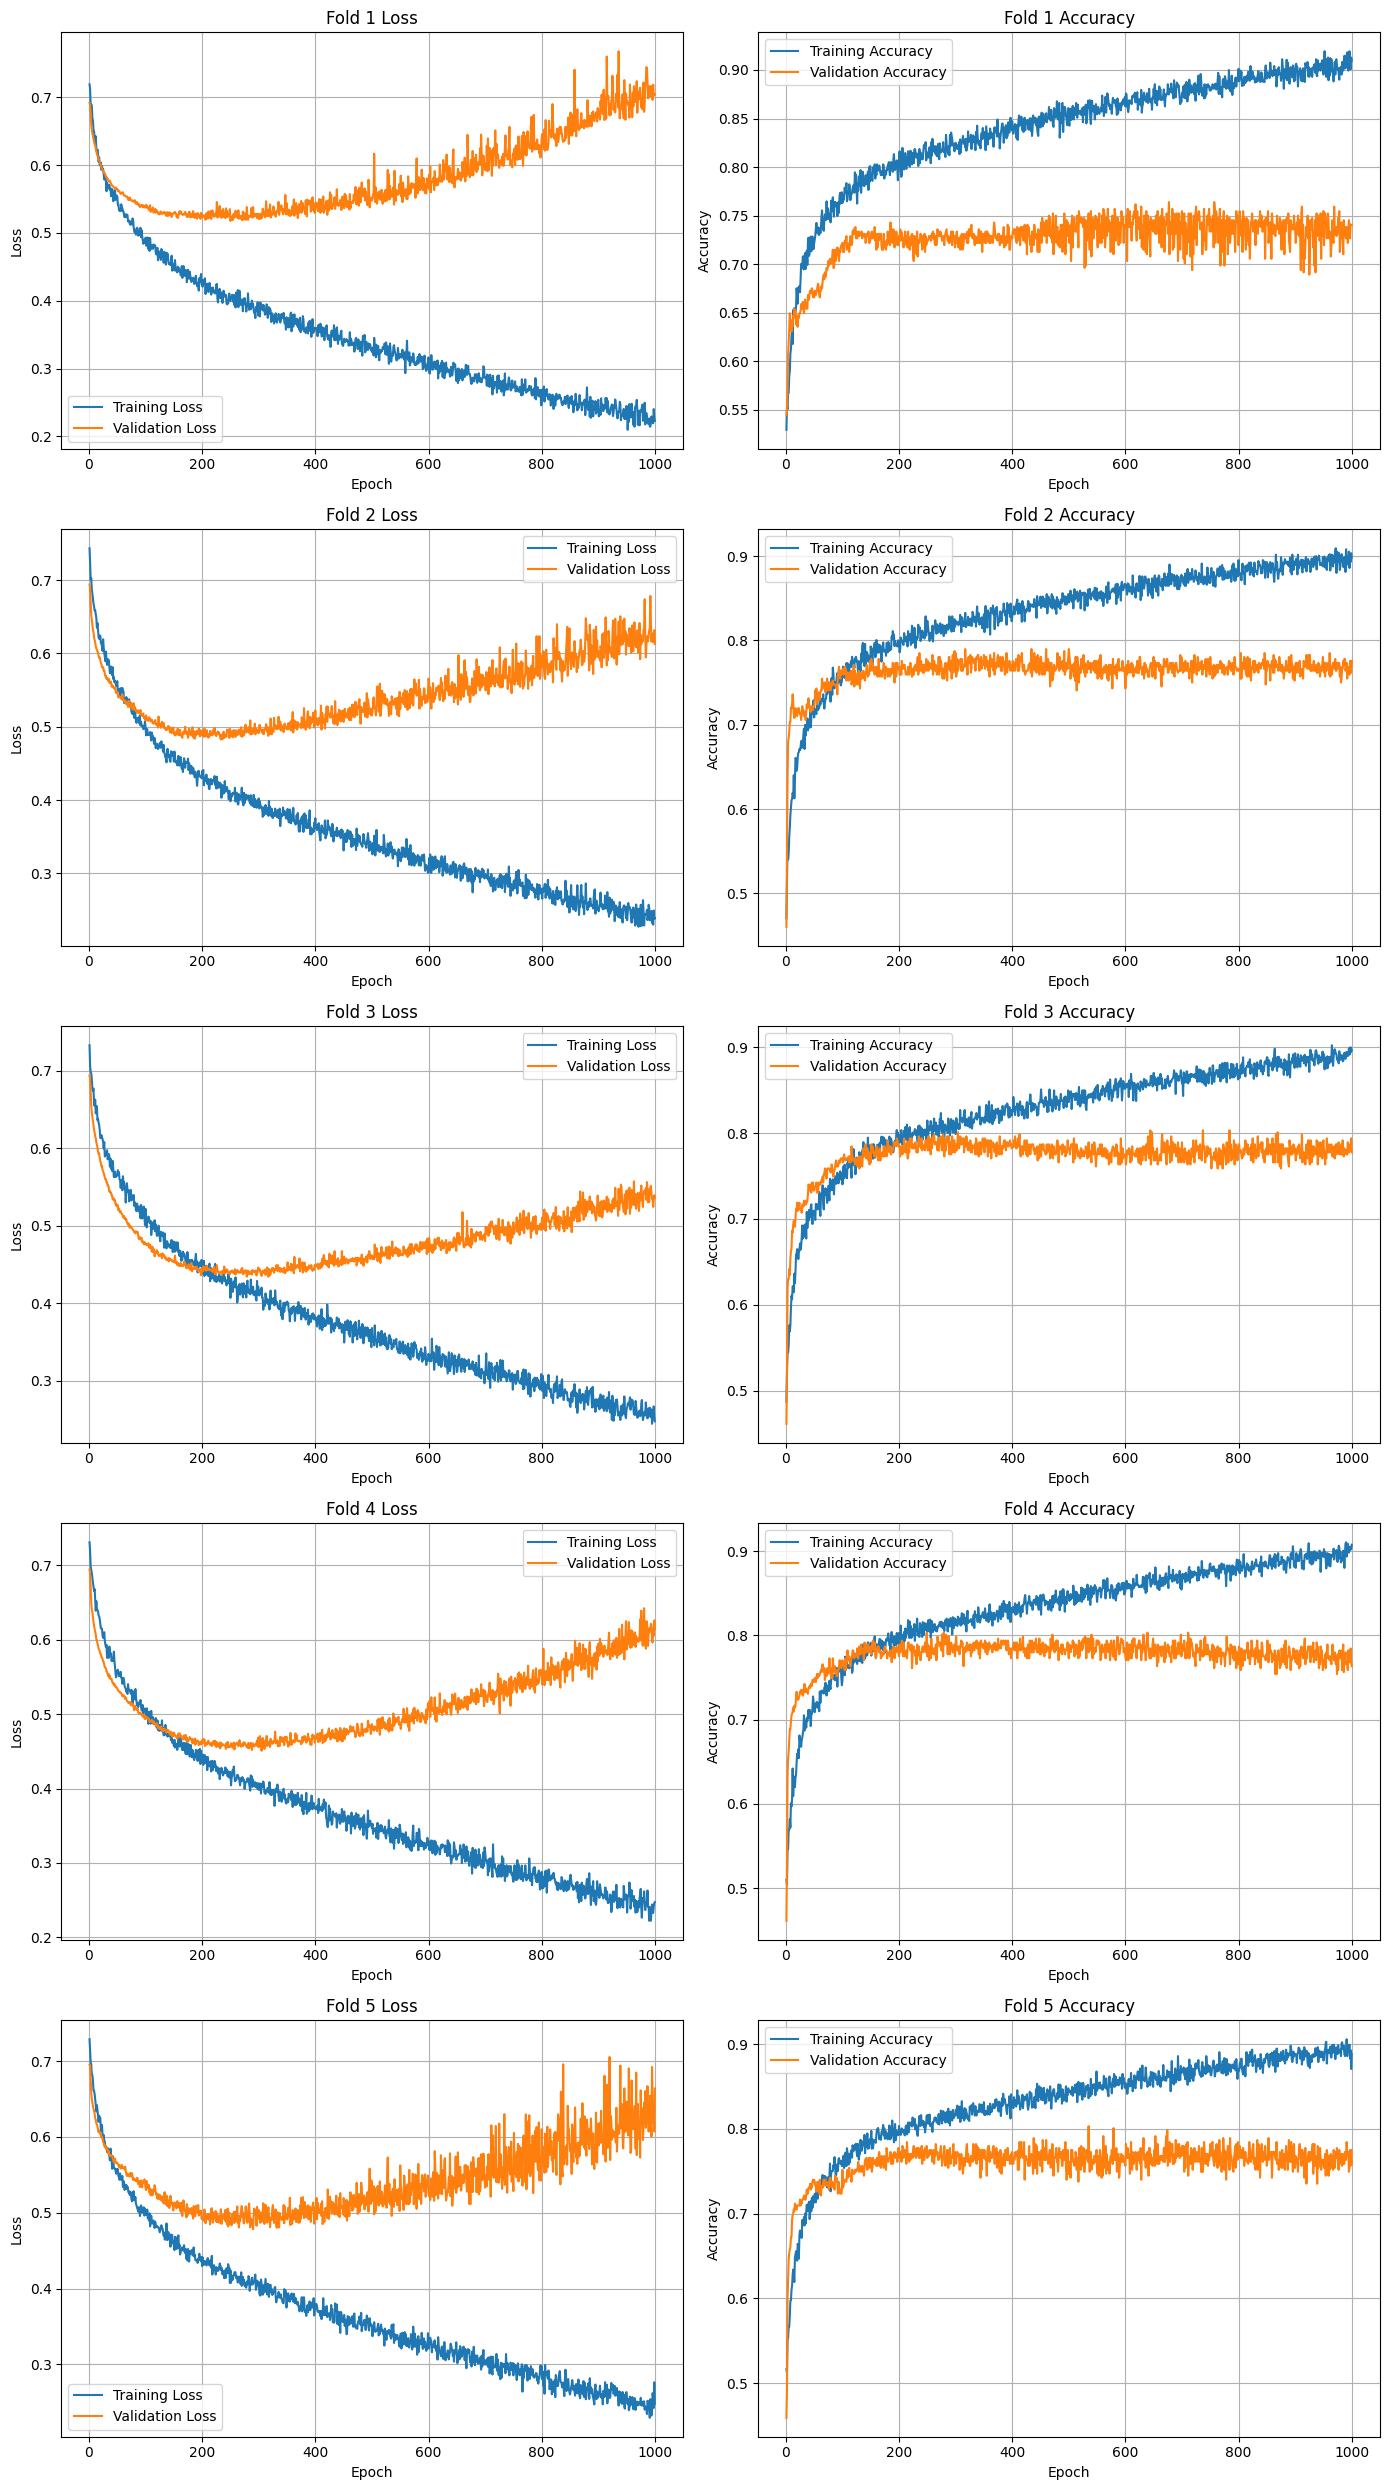

In [11]:
fig, axes = plt.subplots(nrows=k_folds, ncols=2, figsize=(14, 5 * k_folds))
axes = axes.reshape(k_folds, 2)

for i, history in enumerate(fold_histories):
    epochs_range = range(1, epochs + 1)
    
    ax_loss = axes[i, 0]
    ax_loss.plot(epochs_range, history["train_loss"], label='Training Loss')
    ax_loss.plot(epochs_range, history["val_loss"], label='Validation Loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title(f'Fold {i + 1} Loss')
    ax_loss.legend()
    ax_loss.grid(True)
    
    ax_acc = axes[i, 1]
    ax_acc.plot(epochs_range, history["train_accuracy"], label='Training Accuracy')
    ax_acc.plot(epochs_range, history["val_accuracy"], label='Validation Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title(f'Fold {i + 1} Accuracy')
    ax_acc.legend()
    ax_acc.grid(True)

plt.tight_layout()
plt.show()

After experimenting a bit, according to this CV it seems like the (sub)optimal model is the one using Adam with learning rate 1e-5 and weight decay 1e-5. Moreover, it seems like a good stopping point is at 200, after which we observe overfitting. 

In [22]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
epochs = 200
batch_size = 64
X_full_tensor = torch.tensor(X, dtype=torch.float32)
y_full_tensor = torch.tensor(y, dtype=torch.float32)
full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)
final_model = BertweetBaseMLP(embedding_dim).to(device)
final_optimizer = optim.AdamW(final_model.parameters(), lr=1e-5, weight_decay=1e-5)
final_history = train_and_validate_model(final_model, full_loader, None, criterion, final_optimizer, device, epochs, seed, use_tqdm=False)
torch.save(final_model.state_dict(), "models/bertweet_base.pt")

Epoch 1/200
Training Loss: 0.7129, Accuracy: 0.5321
Epoch 2/200
Training Loss: 0.7088, Accuracy: 0.5452
Epoch 3/200
Training Loss: 0.6913, Accuracy: 0.5578
Epoch 4/200
Training Loss: 0.6890, Accuracy: 0.5601
Epoch 5/200
Training Loss: 0.6718, Accuracy: 0.5704
Epoch 6/200
Training Loss: 0.6631, Accuracy: 0.5868
Epoch 7/200
Training Loss: 0.6540, Accuracy: 0.6022
Epoch 8/200
Training Loss: 0.6515, Accuracy: 0.6125
Epoch 9/200
Training Loss: 0.6468, Accuracy: 0.6153
Epoch 10/200
Training Loss: 0.6447, Accuracy: 0.6083
Epoch 11/200
Training Loss: 0.6309, Accuracy: 0.6270
Epoch 12/200
Training Loss: 0.6240, Accuracy: 0.6434
Epoch 13/200
Training Loss: 0.6297, Accuracy: 0.6224
Epoch 14/200
Training Loss: 0.6193, Accuracy: 0.6476
Epoch 15/200
Training Loss: 0.6206, Accuracy: 0.6453
Epoch 16/200
Training Loss: 0.6175, Accuracy: 0.6467
Epoch 17/200
Training Loss: 0.6172, Accuracy: 0.6556
Epoch 18/200
Training Loss: 0.6037, Accuracy: 0.6603
Epoch 19/200
Training Loss: 0.6048, Accuracy: 0.6715
Ep

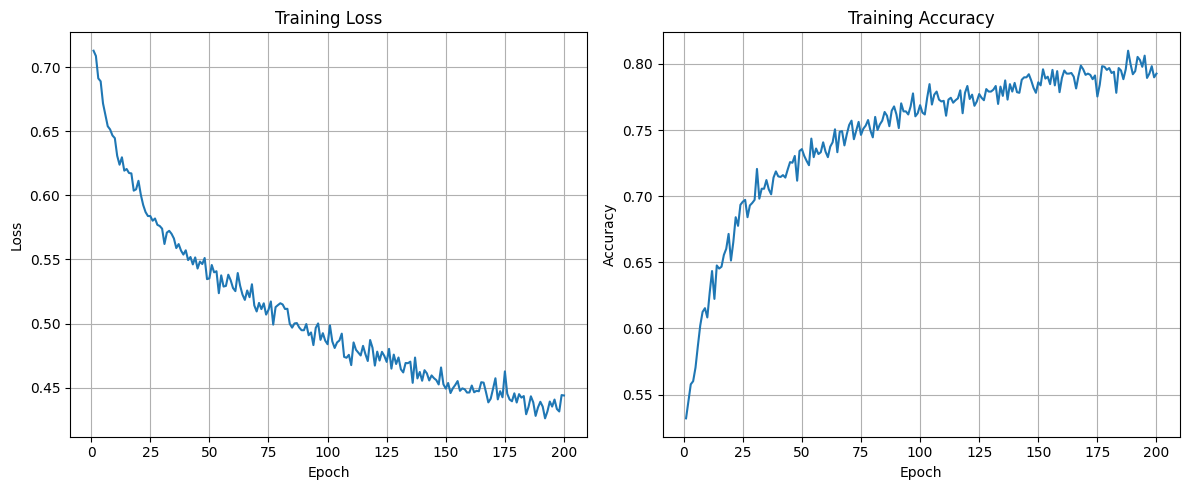

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) 
plt.plot(range(1, epochs + 1), final_history["train_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), final_history["train_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing

Let's test the model for the submission.

In [24]:
file_path = "processed_data/aggregated_embeddings_with_labels_test.pkl"
merged_df_test = pd.read_pickle(file_path)
X_test = np.vstack(merged_df_test["aggregated_embedding"].values)

In [25]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[-0.005626861, 0.17002444, 0.1560707, -0.07122...",15
1,15_1,"[-0.012398133, 0.16987626, 0.15416442, -0.0715...",15
2,15_10,"[-0.0063685165, 0.17705764, 0.14571677, -0.061...",15
3,15_100,"[-0.028167112, 0.21267831, 0.11889246, -0.0327...",15
4,15_101,"[-0.021408508, 0.20869574, 0.12005638, -0.0342...",15
...,...,...,...
511,9_95,"[-0.06389925, 0.15774356, 0.10894526, -0.06712...",9
512,9_96,"[-0.06254904, 0.16254315, 0.10645582, -0.07547...",9
513,9_97,"[-0.06544371, 0.15834767, 0.1077392, -0.078381...",9
514,9_98,"[-0.061433755, 0.15302086, 0.0968332, -0.06357...",9


In [26]:
X_test.shape

(516, 768)

In [27]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

In [28]:
# embedding_dim = X_test.shape[1]
# final_model = BertweetBaseMLP(embedding_dim)
# final_model.load_state_dict(torch.load("models/bertweet_base.pt"))
# final_model = final_model.to(device)

In [29]:
final_model.eval()
with torch.no_grad():
    logits = final_model(X_test_tensor).squeeze()  
    predictions = (torch.sigmoid(logits) >= 0.5).int().cpu().numpy()
    
final_df = pd.DataFrame({
    "ID": merged_df_test["ID"],
    "EventType": predictions  # Add predictions as EventType
})    

In [30]:
final_df

,ID,EventType
0,15_0,1
1,15_1,1
2,15_10,0
3,15_100,1
4,15_101,1
...,...,...
511,9_95,0
512,9_96,0
513,9_97,0
514,9_98,0


In [31]:
final_df.to_csv("predictions/bertweet_base_predictions.csv", index=False)